# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [4]:
ds_train = pd.read_csv("C:/Users/maico/Documents/Mestrado/dmeyf2023/datasets/competencia_02.csv")

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [5]:
ds_hist = ds_train[ds_train["numero_de_cliente"].isin(ds_train[ds_train["clase_ternaria"] == "BAJA+2"]["numero_de_cliente"])]
ds_hist.drop(columns=["clase_ternaria"], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
clase_train = ds_train["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)

ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'num_iterations': 670,
    'learning_rate': 0.0100738668153211,
    'feature_fraction': 0.413040235996875,
    'verbose': -100,
    'max_bin': 31,
    'min_data_in_leaf': 2858,
    'num_leaves:': 161,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Found `num_iterations` in params. Will use it instead of argument


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [8]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
0,foto_mes,1641
15,mcuenta_corriente,730
32,mprestamos_personales,714
152,Visa_mpagominimo,571
21,mcuentas_saldo,560
...,...,...
121,Master_madelantodolares,0
53,cpayroll2_trx,0
39,mplazo_fijo_pesos,0
52,mpayroll2,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [9]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [10]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.006493806920363942


,1103,7
mcuentas_saldo,630720.66,0.363873
mcaja_ahorro,631674.59,0.196651
mpasivos_margen,16383.16,0.099831
cproductos,9.00,0.098284
mcuenta_corriente,0.00,0.064925
...,...,...
mtarjeta_visa_consumo,0.00,-0.196068
foto_mes,201901.00,-0.196747
cpayroll_trx,0.00,-0.381011
mpayroll,0.00,-0.386554


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [11]:
shap_bajas.mean().abs().sort_values(ascending=False)


ctrx_quarter                   0.456624
mcaja_ahorro                   0.343621
mpayroll                       0.322601
cpayroll_trx                   0.283491
foto_mes                       0.218851
                                 ...   
cpagodeservicios               0.000000
mpagodeservicios               0.000000
ctarjeta_master_descuentos     0.000000
mtarjeta_master_descuentos     0.000000
mcuenta_corriente_adicional    0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

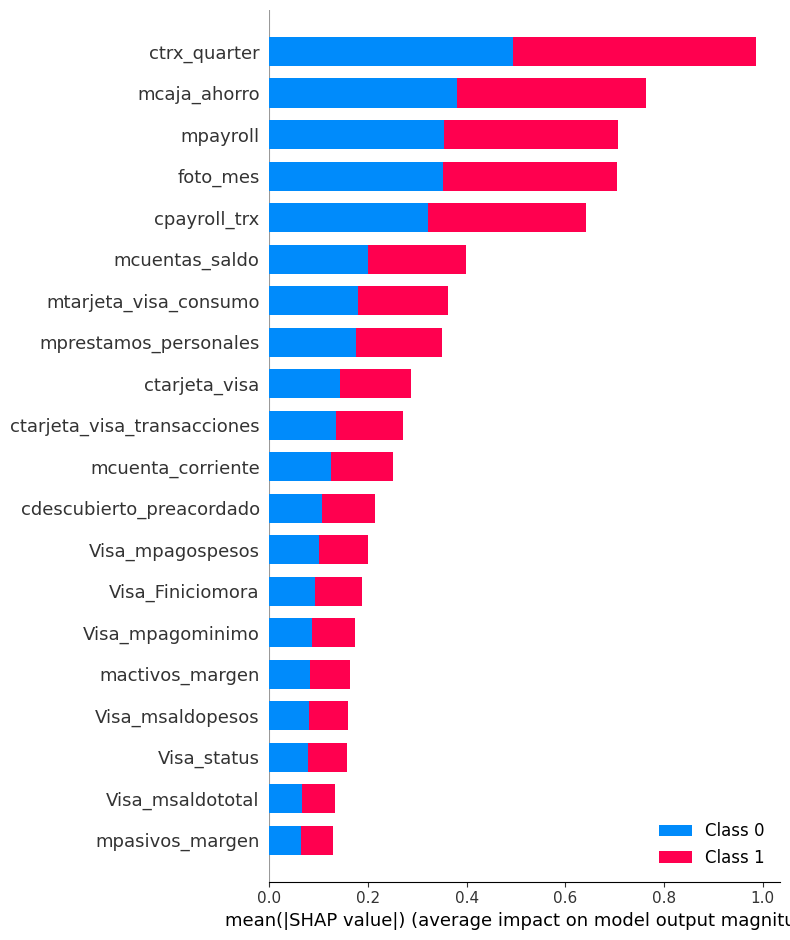

In [12]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

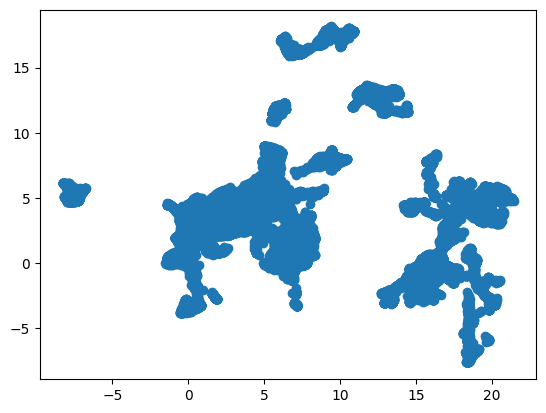

In [13]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

In [14]:
p_bajas.size

38267

(array([1.5275e+04, 6.7000e+03, 3.9320e+03, 2.7420e+03, 2.0530e+03,
        1.5810e+03, 1.3970e+03, 1.1180e+03, 9.1800e+02, 6.6100e+02,
        4.7900e+02, 3.5000e+02, 2.7300e+02, 1.3200e+02, 1.1400e+02,
        8.4000e+01, 9.7000e+01, 7.4000e+01, 4.3000e+01, 3.8000e+01,
        4.0000e+01, 3.9000e+01, 3.6000e+01, 3.8000e+01, 2.6000e+01,
        1.4000e+01, 4.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([4.80067950e-05, 2.66136305e-02, 5.31792542e-02, 7.97448779e-02,
        1.06310502e-01, 1.32876125e-01, 1.59441749e-01, 1.86007373e-01,
        2.12572996e-01, 2.39138620e-01, 2.65704244e-01, 2.92269868e-01,
        3.18835491e-01, 3.45401115e-01, 3.71966739e-01, 3.98532362e-01,
        4.25097986e-01, 4.51663610e-01, 4.78229234e-01, 5.04794857e-01,
        5.31360481e-01, 5.57926105e-01, 5.84491728e-01, 6.11057352e-01,
        6.37622976e-01, 6.64188600e-01, 6.90754223e-01, 7.17319847e-01,
        7.43885471e-01, 7.70451094e-01, 7.97016718e-01]),
 <BarContainer object of 30 

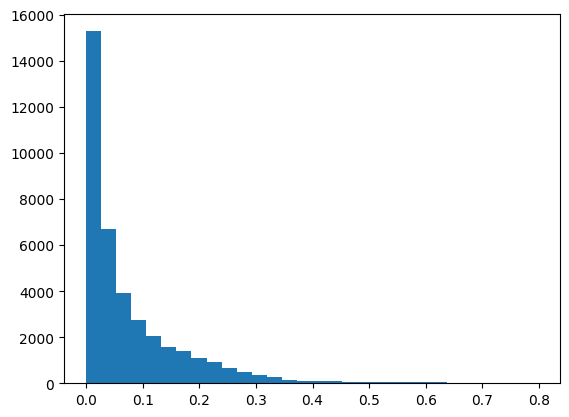

In [15]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

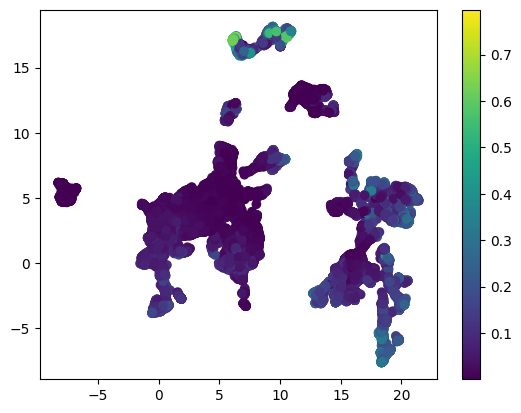

In [16]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


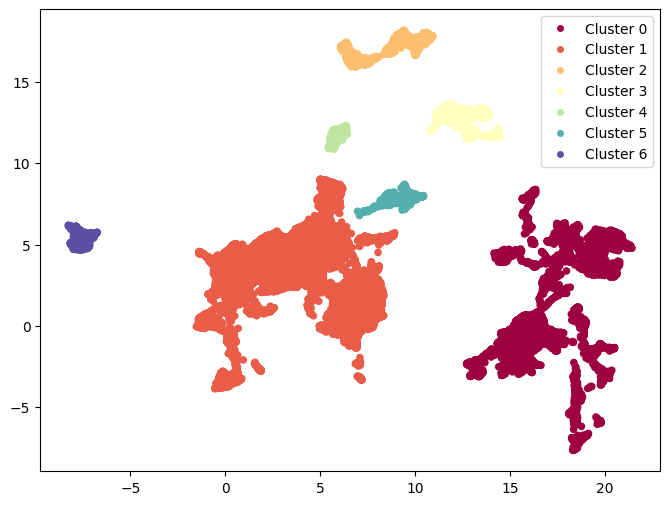

In [17]:
from matplotlib.lines import Line2D  # Importe Line2D


hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

unique_labels = set(y.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='Spectral', marker='o', s=20)

legend_labels = [f'Cluster {label}' if label != -1 else 'Outliers' for label in unique_labels]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label]) for label in unique_labels]

plt.legend(legend_handles, legend_labels, loc='upper right')

plt.show()


In [56]:
np.unique(y.labels_)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Comparamos 2 clusters para ver si cambian sus variables importantes

In [57]:
shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)

chomebanking_transacciones           0.023677
ctarjeta_visa_debitos_automaticos    0.018405
mtransferencias_emitidas             0.013418
thomebanking                         0.008005
Visa_cadelantosefectivo              0.003590
                                       ...   
mpayroll                            -0.298372
cpayroll_trx                        -0.319584
ctarjeta_visa                       -0.367722
mcaja_ahorro                        -0.446076
ctrx_quarter                        -0.562292
Length: 153, dtype: float64

In [58]:
#criar um novo dataset com os labels
ds_bajas_labels = ds_bajas.copy()
ds_bajas_labels["labels"] = y.labels_

In [59]:
#exibir os labels dos clientes que tem cpayroll_trx > 0
ds_bajas_labels[ds_bajas_labels['cpayroll_trx'] > 0]['labels'].value_counts()

labels
3    1094
1      60
4      53
2      37
0       3
Name: count, dtype: int64

Grupo 5 tem contas que nao recebem salario

In [219]:
shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)

chomebanking_transacciones           0.023677
ctarjeta_visa_debitos_automaticos    0.018405
mtransferencias_emitidas             0.013418
thomebanking                         0.008005
Visa_cadelantosefectivo              0.003590
                                       ...   
mpayroll                            -0.298372
cpayroll_trx                        -0.319584
ctarjeta_visa                       -0.367722
mcaja_ahorro                        -0.446076
ctrx_quarter                        -0.562292
Length: 153, dtype: float64

In [141]:
#criar um novo dataset copia de ds_bajas adicionando o numero_de_cliente que vai ser igual ao numero_de_cliente do ds_hist aonde o index for igual , usar ds_hist.index.get_loc() para localizar o index do cliente no ds_hist
ds_historico_bajas = ds_bajas_labels.copy()
ds_historico_bajas['numero_de_cliente'] = ds_hist.loc[ds_bajas_labels.index, 'numero_de_cliente']

In [202]:
ds_historico_final = pd.concat([ds_historico_bajas, ds_hist], axis=0)   
ds_historico_final['labels'].fillna(ds_historico_final.groupby('numero_de_cliente')['labels'].transform('first'), inplace=True)
ds_historico_final.drop_duplicates(subset=['numero_de_cliente', 'foto_mes'], keep='last', inplace=True)

In [19]:
ds_historico_final.groupby(['foto_mes', 'labels'])['cpayroll_trx'].mean().unstack()

NameError: name 'ds_historico_final' is not defined

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponha que você tenha um DataFrame chamado 'ds_historico_final' com as colunas 'numero_de_cliente', 'foto_mes', 'label' e 'chomebanking_transacciones'
# Certifique-se de que o DataFrame esteja carregado corretamente

# Converter a coluna 'foto_mes' para o formato de data, se já não estiver

# Crie um gráfico de linhas para cada rótulo
plt.figure(figsize=(12, 6))

# Agrupe o DataFrame por 'label' e 'foto_mes' e calcule a média de 'chomebanking_transacciones'
grouped = ds_historico_final.groupby(['foto_mes', 'labels'])['inversiones'].mean().unstack()

# Plote as linhas para cada rótulo
for label, data in grouped.items():
    plt.plot(data.index, data, label=label)

# Configurações de legenda e rótulos de eixo
plt.legend(title='Label')
plt.xlabel('Mês')
plt.ylabel('chomebanking_transacciones')
plt.title('Evolução de chomebanking_transacciones por Label')

# Mostrar o gráfico
plt.show()


NameError: name 'ds_historico_final' is not defined

<Figure size 1200x600 with 0 Axes>

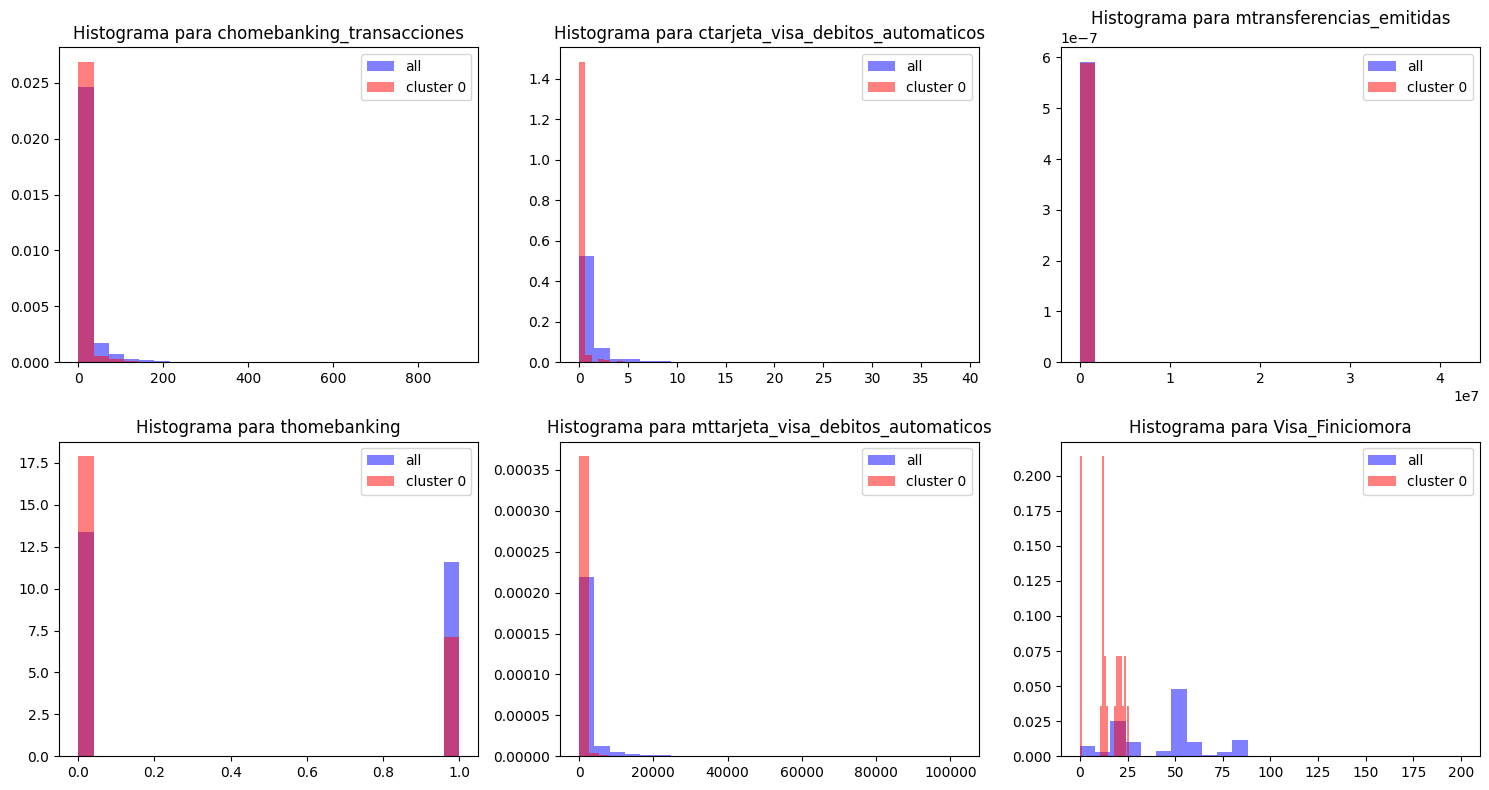

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 0][feature_names[i]], label='cluster 0', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [ ]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)


ctarjeta_visa                 0.015068
chomebanking_transacciones    0.012106
cdescubierto_preacordado      0.009911
Visa_status                   0.009830
Visa_delinquency              0.009634
                                ...   
foto_mes                     -0.271944
mcaja_ahorro                 -0.279088
cpayroll_trx                 -0.337313
mpayroll                     -0.379138
ctrx_quarter                 -0.505113
Length: 154, dtype: float64

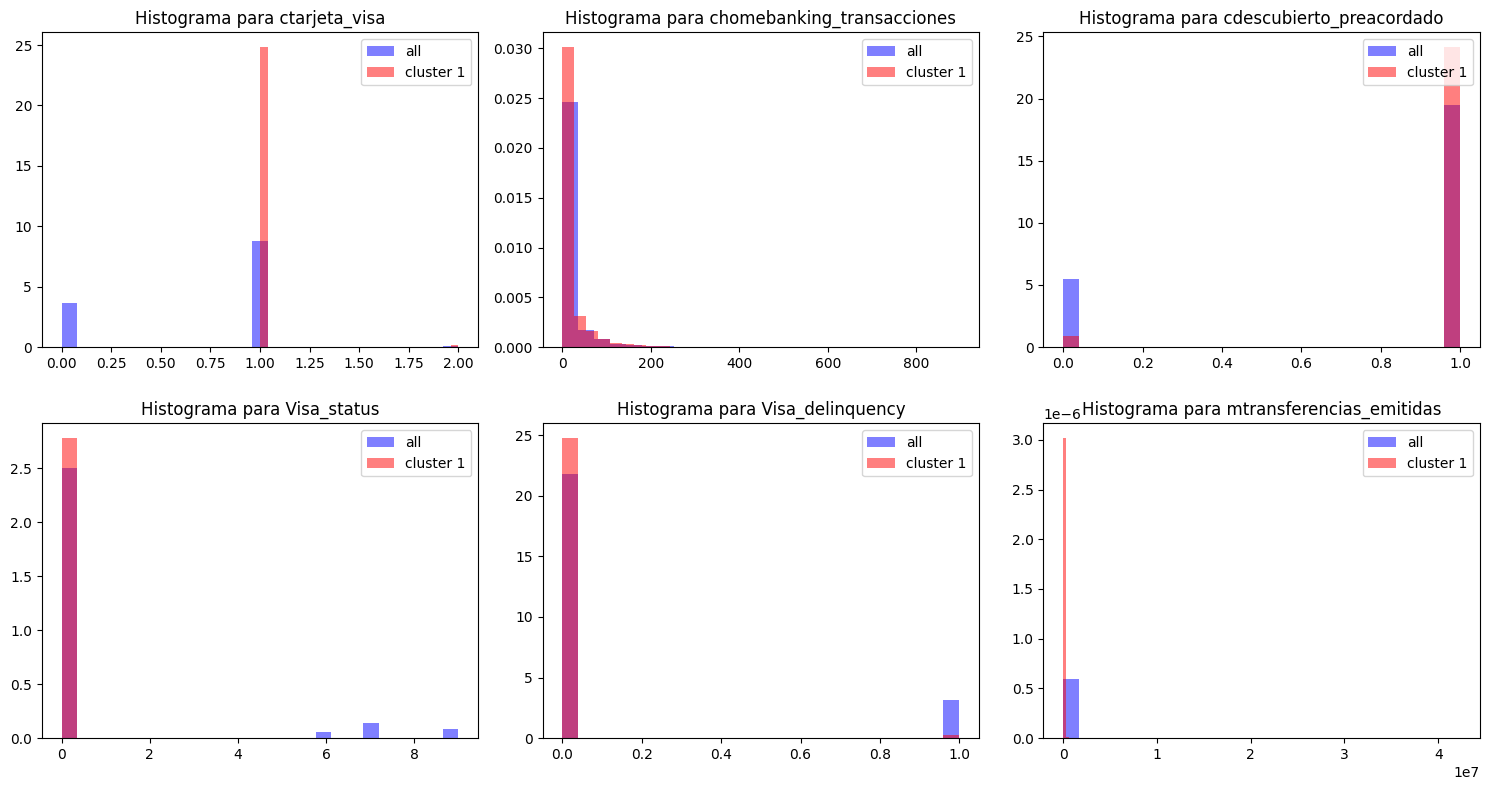

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 1][feature_names[i]], label='cluster 1', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [ ]:
shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)

mprestamos_personales         0.068090
internet                      0.011701
mtransferencias_emitidas      0.009998
chomebanking_transacciones    0.009655
thomebanking                  0.003610
                                ...   
Master_Finiciomora           -0.298032
mcuentas_saldo               -0.317380
foto_mes                     -0.467594
mcaja_ahorro                 -0.635932
Visa_Finiciomora             -0.797478
Length: 154, dtype: float64

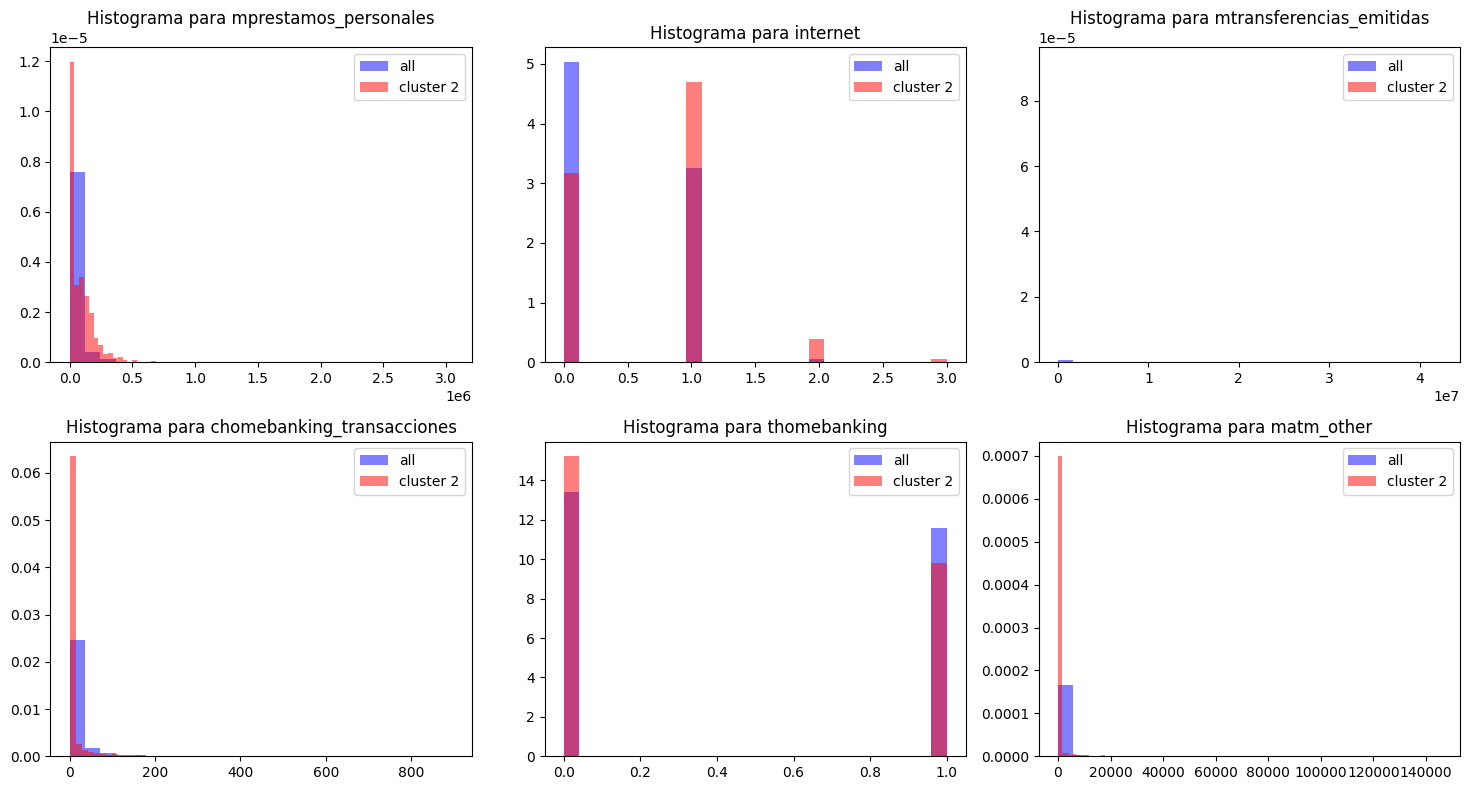

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 2][feature_names[i]], label='cluster 2', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [ ]:
shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)

cpayroll_trx                         0.335092
mpayroll                             0.248303
cextraccion_autoservicio             0.004153
mextraccion_autoservicio             0.003226
ctarjeta_visa_debitos_automaticos    0.002404
                                       ...   
mtarjeta_visa_consumo               -0.069070
ctarjeta_visa                       -0.085929
Visa_mpagominimo                    -0.098473
ccaja_ahorro                        -0.099772
foto_mes                            -0.228302
Length: 154, dtype: float64

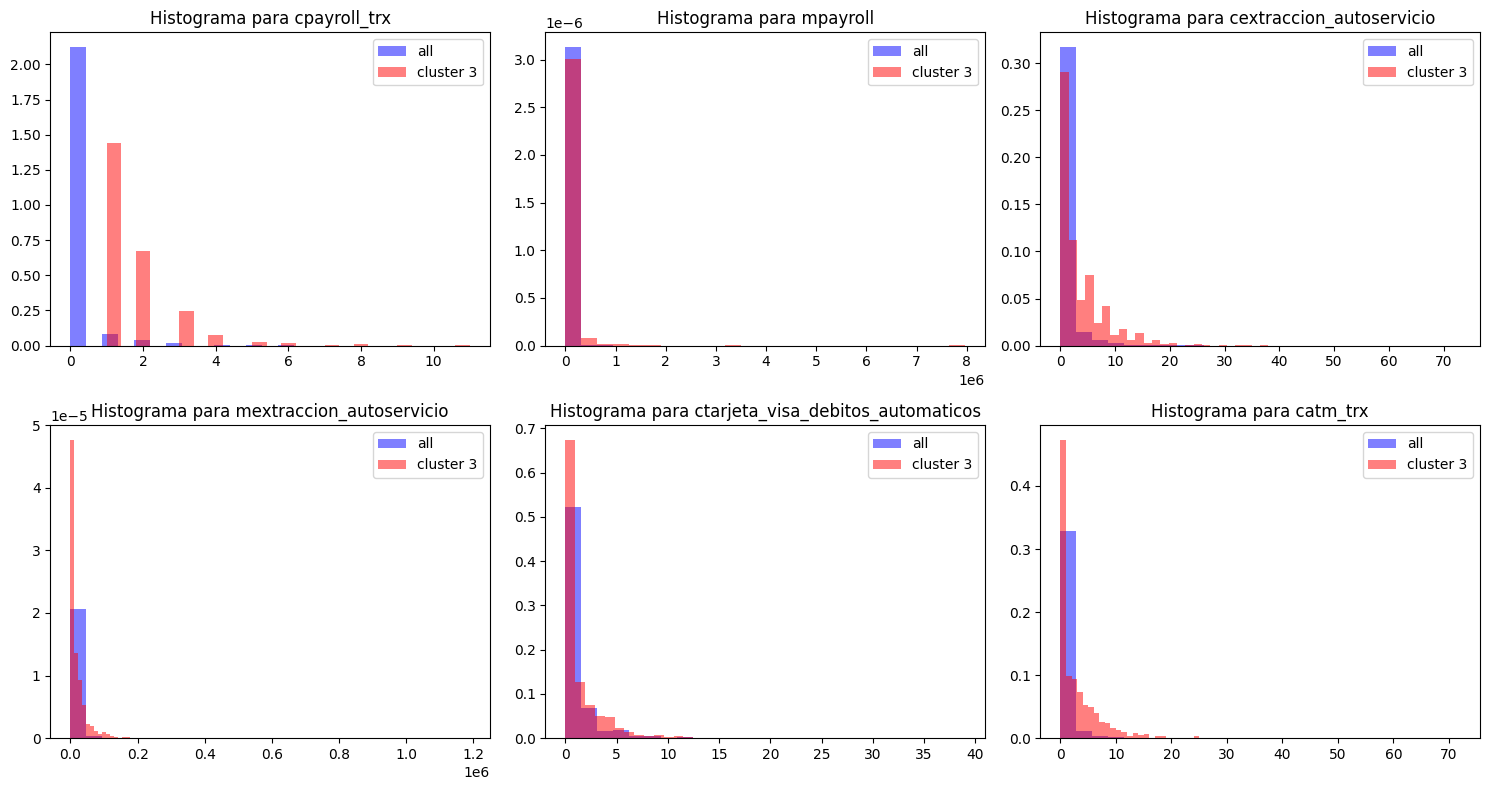

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 3][feature_names[i]], label='cluster 3', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [ ]:
shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)

mprestamos_personales         0.055253
mtransferencias_emitidas      0.010464
Visa_msaldototal              0.009682
chomebanking_transacciones    0.008899
ctarjeta_visa                 0.007977
                                ...   
mcuentas_saldo               -0.343556
Visa_delinquency             -0.382034
foto_mes                     -0.523130
mcaja_ahorro                 -0.767591
Visa_Finiciomora             -1.838003
Length: 154, dtype: float64

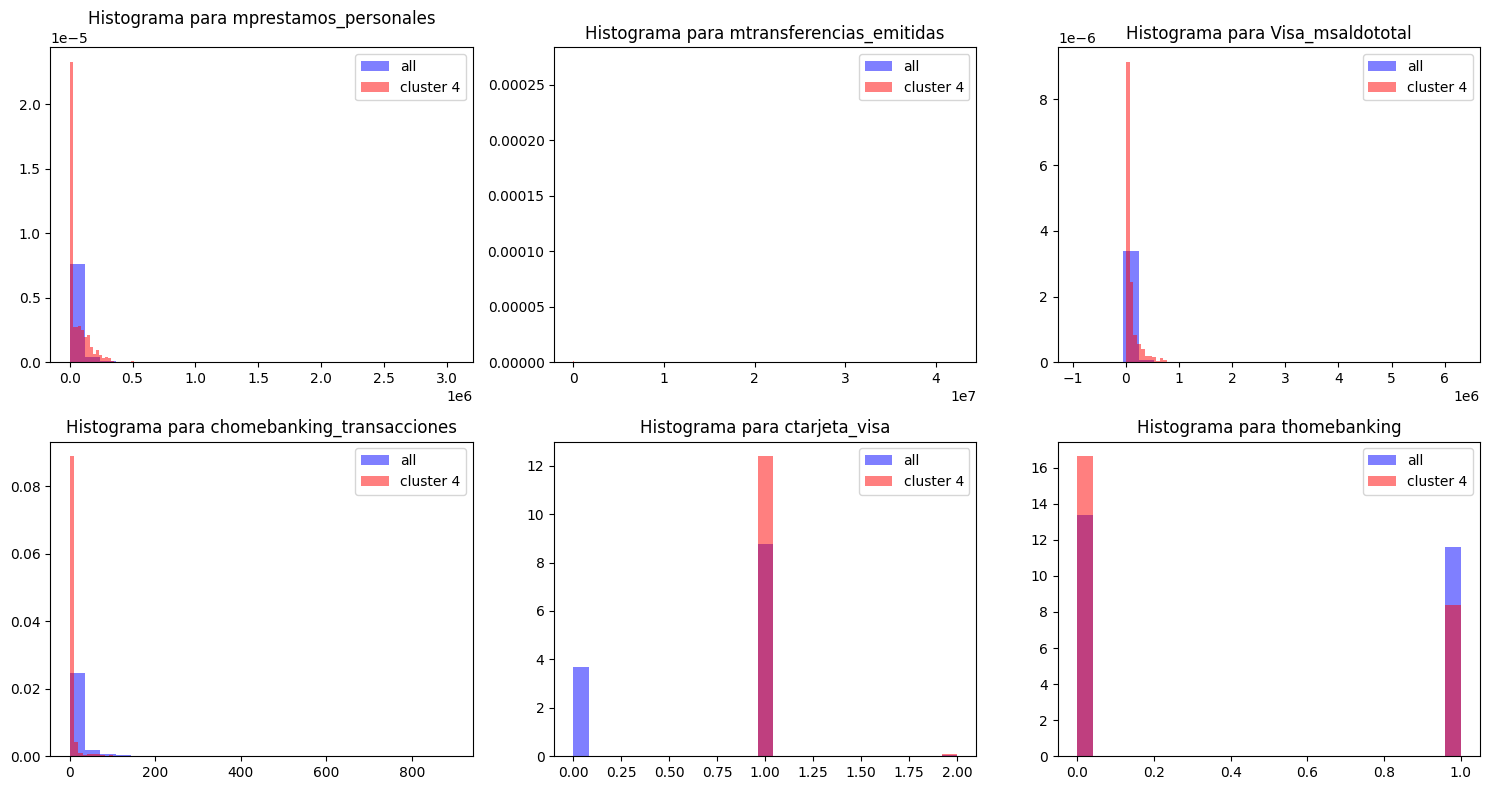

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 4][feature_names[i]], label='cluster 4', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


In [ ]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

Master_fechaalta              0.326635
Visa_fechaalta                0.093482
mcuenta_corriente             0.046781
tcuentas                      0.039273
chomebanking_transacciones    0.038984
                                ...   
mtarjeta_visa_consumo        -0.154196
mpayroll                     -0.318968
cpayroll_trx                 -0.333137
mcaja_ahorro                 -0.406674
ctrx_quarter                 -0.603195
Length: 154, dtype: float64

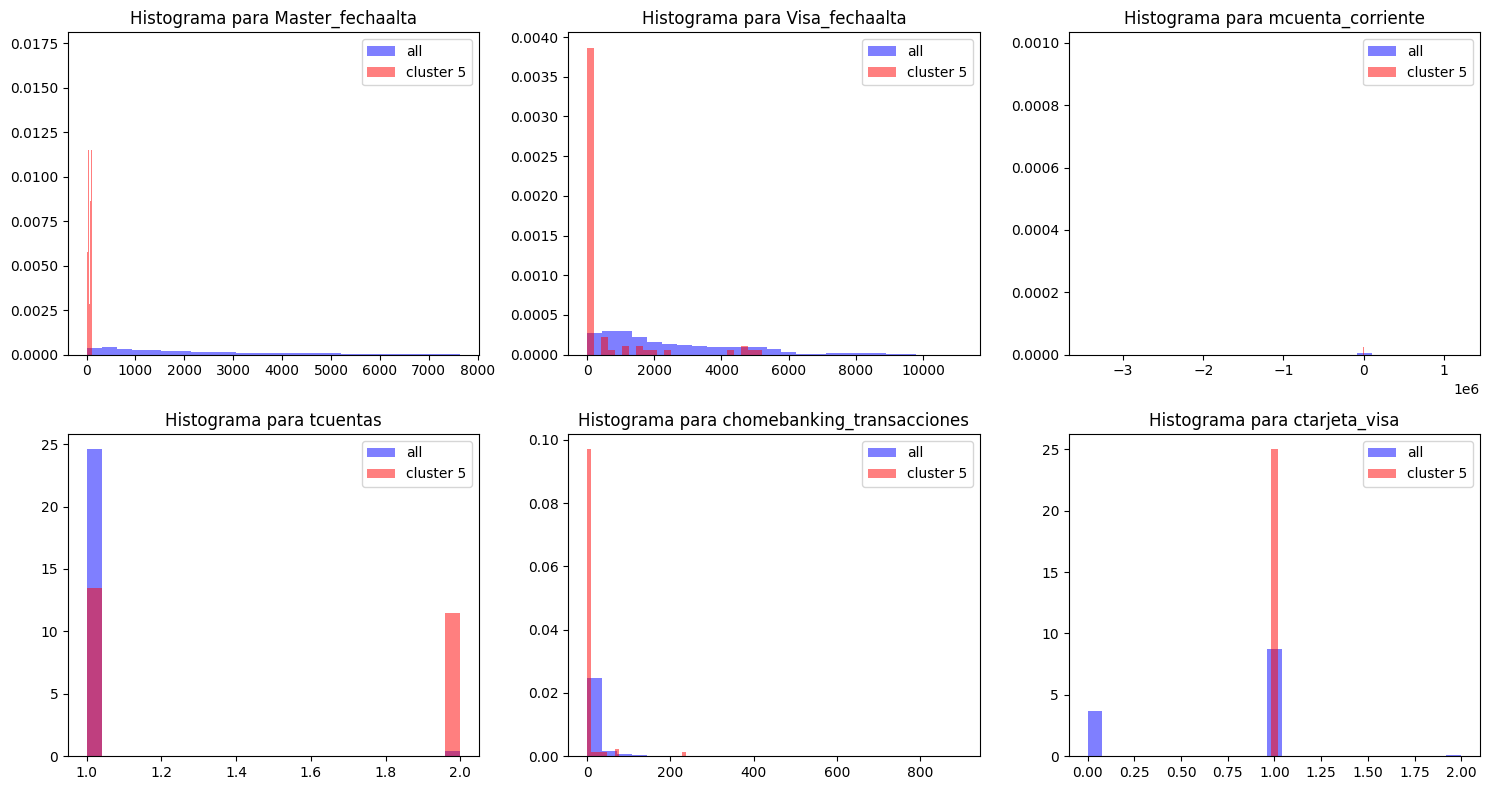

In [ ]:
values_to_plot = shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)[0:6].values
feature_names = shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)[0:6].index.to_list()

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten os eixos para acessá-los facilmente
axs = axs.ravel()

# Crie os gráficos de histograma
for i in range(6):
    ax = axs[i]
    ax.hist(ds_bajas.loc[:][feature_names[i]], label='all', density=True, bins=25, alpha=0.5, color='blue')
    ax.hist(ds_bajas.loc[y.labels_ == 5][feature_names[i]], label='cluster 5', density=True, bins=25, alpha=0.5, color='red')
    ax.set_title(f'Histograma para {feature_names[i]}')
    ax.legend(loc='upper right')

# Ajuste o layout
plt.tight_layout()

# Exiba os gráficos
plt.show()


Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [214]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].sample(1000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [215]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [216]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

using precomputed metric; inverse_transform will be unavailable


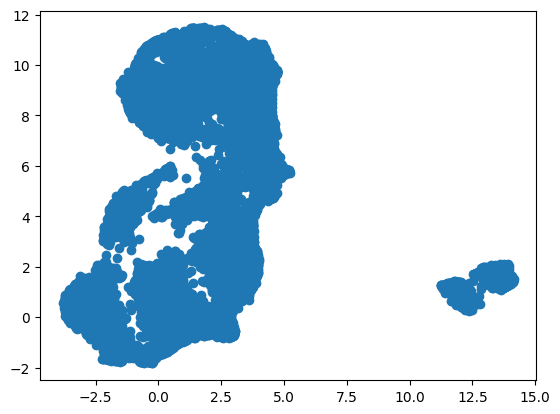

In [220]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

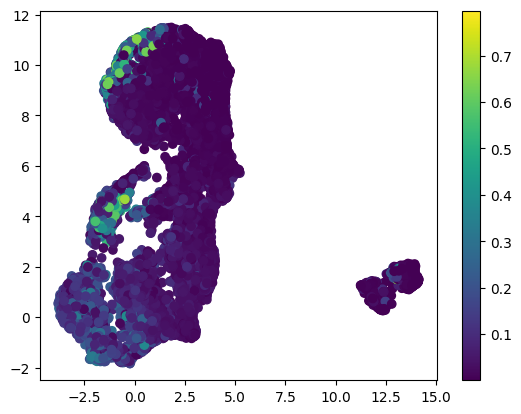

In [221]:
sc = plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=p_bajas)
plt.colorbar(sc)
plt.show()

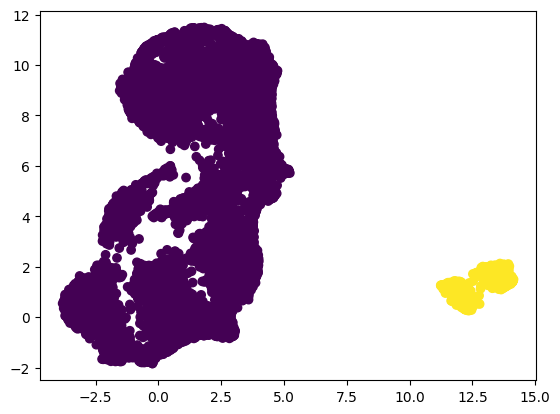

In [222]:
hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y_rf = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y_rf.labels_)
plt.show()

In [223]:
#listar os labels unicos
np.unique(y_rf.labels_).tolist()

[0, 1]